# Train DDC Model for Conditional Generation

In [1]:
# change working path to the current file
%cd ..

/home/hudongcheng/Desktop/bo_osda_generator


In [2]:
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from tqdm import tqdm
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import torch.backends.cudnn as cudnn

# import custom modules
from models.ddc import SMILESGenerator
from utils.utils import *
from datasets.data_loader import *
from utils.plot_figures import *
from utils.metrics import *
from utils.build_vocab import *

In [3]:
cudnn.benchmark = True
cudnn.enabled = True

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

log_dir = './logs/'
save_best_weight_path = './checkpoints/'

now = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

In [4]:
PAD = 0
UNK = 1
EOS = 2
SOS = 3
MASK = 4
MAX_LEN = 220

In [5]:
# read the data and convert to the format we need
train_smiles = read_strings('./data/train_smiles.csv', idx=False)
train_zeo = read_vec('./data/train_zeo.csv', idx=False)
train_syn = read_vec('./data/train_syn.csv', idx=False)
train_codes = read_strings('./data/train_codes.csv', idx=False)
test_smiles = read_strings('./data/test_smiles.csv', idx=False)
test_zeo = read_vec('./data/test_zeo.csv', idx=False)
test_syn = read_vec('./data/test_syn.csv', idx=False)
test_codes = read_strings('./data/test_codes.csv', idx=False)

vocab = WordVocab.load_vocab('./model_hub/vocab.pkl')
print('the vocab size is :', len(vocab))

charlen = len(vocab)
print('the total num of charset is :', charlen)

the vocab size is : 45
the total num of charset is : 45


In [6]:
# hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 512
epoch = 20

In [7]:
# create the dataset and dataloader
train_dataset = Seq2seqDataset(train_zeo, train_syn, train_smiles, vocab)
test_dataset = Seq2seqDataset(test_zeo, test_syn, test_smiles, vocab)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# create the model
model = SMILESGenerator(condition_dim=24, lstm_dim=256, dec_layers=3, charset_size=charlen).to(device)
# loss
loss_func = torch.nn.CrossEntropyLoss(ignore_index=PAD)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
total = sum(p.numel() for p in model.parameters())
print('total parameters: %0.2fM' % (total / 1e6))

total parameters: 1.41M


In [8]:
# train function
def train(model, dataloader, loss_func, optim, device):
    model.train()
    total_loss = 0
    total_acc = 0
    total_num = 0
    for i, (zeo, syn, tgt) in enumerate(tqdm(dataloader)):
        zeo = zeo.to(device)
        syn = syn.to(device)
        tgt = tgt.to(device)
        # teacher forcing
        condition = torch.cat([zeo, syn], dim=-1)
        tgt_input = tgt[:, :-1].contiguous()
        tgt_output = tgt[:, 1:].contiguous()
        # convert the tgt_input to one-hot
        tgt_input = F.one_hot(tgt_input, num_classes=charlen).float()
        
        optim.zero_grad()
        output = model(condition, tgt_input)
        
        # reshape the output to calculate the loss
        output = output.view(-1, output.size(-1))
        tgt_output = tgt_output.view(-1)
        loss = loss_func(output, tgt_output)
        
        # backward and update
        loss.backward()
        optim.step()
        
        # calculate the accuracy and loss
        total_loss += loss.item()
        pred = output.argmax(dim=-1)
        num_correct = (pred == tgt_output) & (tgt_output != PAD)
        num_words = (tgt_output != PAD).sum().item()
        total_acc += num_correct.sum().item()
        total_num += num_words
    return total_loss / len(dataloader), total_acc / total_num

In [9]:
# test function
def test(model, dataloader, loss_func, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_num = 0
    with torch.no_grad():
        for i, (zeo, syn, tgt) in enumerate(tqdm(dataloader)):
            zeo = zeo.to(device)
            syn = syn.to(device)
            tgt = tgt.to(device)
            condition = torch.cat([zeo, syn], dim=-1)
            tgt_input = tgt[:, :-1].contiguous()
            tgt_output = tgt[:, 1:].contiguous()
            tgt_input = F.one_hot(tgt_input, num_classes=charlen).float()
            output = model(condition, tgt_input)
            output = output.view(-1, output.size(-1))
            tgt_output = tgt_output.view(-1)
            loss = loss_func(output, tgt_output)
            total_loss += loss.item()
            pred = output.argmax(dim=-1)
            num_correct = (pred == tgt_output) & (tgt_output != PAD)
            num_words = (tgt_output != PAD).sum().item()
            total_acc += num_correct.sum().item()
            total_num += num_words
    return total_loss / len(dataloader), total_acc / total_num

In [10]:
# train the model
for i in range(epoch):
    train_loss, train_acc = train(model, train_dataloader, loss_func, optim, device)
    test_loss, test_acc = test(model, test_dataloader, loss_func, device)
    print('epoch %d, train loss %.4f, train acc %.4f, test loss %.4f, test acc %.4f' % (i, train_loss, train_acc, test_loss, test_acc))
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    if i == 0:
        best_acc = test_acc
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), os.path.join(save_best_weight_path, 'best_ddc_model.pth'))
    torch.save(model.state_dict(), os.path.join(save_best_weight_path, 'last_ddc_model.pth'))

100%|██████████| 68/68 [00:04<00:00, 15.04it/s]


epoch 0, train loss 2.0374, train acc 0.4051, test loss 1.5889, test acc 0.5005


100%|██████████| 68/68 [00:04<00:00, 14.97it/s]


epoch 1, train loss 1.4411, train acc 0.5470, test loss 1.3452, test acc 0.5726


100%|██████████| 68/68 [00:04<00:00, 14.90it/s]


epoch 2, train loss 1.2204, train acc 0.6067, test loss 1.1361, test acc 0.6276


100%|██████████| 68/68 [00:04<00:00, 14.94it/s]


epoch 3, train loss 1.0258, train acc 0.6578, test loss 0.9923, test acc 0.6653


100%|██████████| 68/68 [00:04<00:00, 14.89it/s]


epoch 4, train loss 0.8910, train acc 0.6964, test loss 0.8626, test acc 0.7061


100%|██████████| 68/68 [00:04<00:00, 14.92it/s]


epoch 5, train loss 0.7945, train acc 0.7256, test loss 0.7777, test acc 0.7336


100%|██████████| 68/68 [00:04<00:00, 14.94it/s]


epoch 6, train loss 0.7179, train acc 0.7499, test loss 0.7405, test acc 0.7427


100%|██████████| 68/68 [00:04<00:00, 15.02it/s]


epoch 7, train loss 0.6605, train acc 0.7679, test loss 0.6773, test acc 0.7633


100%|██████████| 68/68 [00:04<00:00, 14.95it/s]


epoch 8, train loss 0.6183, train acc 0.7806, test loss 0.6300, test acc 0.7770


100%|██████████| 68/68 [00:04<00:00, 14.90it/s]


epoch 9, train loss 0.5812, train acc 0.7912, test loss 0.5923, test acc 0.7896


100%|██████████| 68/68 [00:04<00:00, 14.90it/s]


epoch 10, train loss 0.5509, train acc 0.8001, test loss 0.5659, test acc 0.7972


100%|██████████| 68/68 [00:04<00:00, 14.98it/s]


epoch 11, train loss 0.5258, train acc 0.8071, test loss 0.5457, test acc 0.8023


100%|██████████| 68/68 [00:04<00:00, 14.95it/s]


epoch 12, train loss 0.5042, train acc 0.8132, test loss 0.5347, test acc 0.8042


100%|██████████| 68/68 [00:04<00:00, 15.00it/s]


epoch 13, train loss 0.4872, train acc 0.8182, test loss 0.5060, test acc 0.8136


100%|██████████| 68/68 [00:04<00:00, 14.89it/s]


epoch 14, train loss 0.4707, train acc 0.8226, test loss 0.4864, test acc 0.8201


100%|██████████| 68/68 [00:04<00:00, 14.87it/s]


epoch 15, train loss 0.4573, train acc 0.8264, test loss 0.4725, test acc 0.8230


100%|██████████| 68/68 [00:04<00:00, 14.95it/s]


epoch 16, train loss 0.4456, train acc 0.8293, test loss 0.4617, test acc 0.8270


100%|██████████| 68/68 [00:04<00:00, 14.98it/s]


epoch 17, train loss 0.4352, train acc 0.8324, test loss 0.4582, test acc 0.8261


100%|██████████| 68/68 [00:04<00:00, 14.98it/s]


epoch 18, train loss 0.4271, train acc 0.8343, test loss 0.4415, test acc 0.8309


100%|██████████| 68/68 [00:04<00:00, 14.92it/s]

epoch 19, train loss 0.4172, train acc 0.8374, test loss 0.4311, test acc 0.8348


In [11]:
def generate_ddc(model, start_sequence, condition, max_length, vocab,  device, temperature=0.5, top_k=0):
    """
    Autoregressive generation process for a GPT model.

    Args:
        model (ddc): The pre-trained GPT model for token generation.
        start_sequence (torch.Tensor): The initial sequence to start generation (batch_size, seq_length).
        condition_props (torch.Tensor): The conditional property vector (batch_size, num_props).
        max_length (int): The maximum length of the generated sequence.
        vocab: The vocabulary object for encoding and decoding SMILES strings.
        device (torch.device): The device on which to run the generation.
        temperature (float): Temperature parameter for sampling; higher values increase randomness.
        top_k (int): Limits sampling to top-k logits; if 0, no top-k sampling is applied.

    Returns:
        List[str]: A list of generated SMILES strings.
    """

    model.eval()
    batch_size = start_sequence.size(0)
    generated_seq = start_sequence.clone().to(device)
    
    with torch.no_grad():
        # We will iteratively fill positions from [start_len ... seqlen-1]
        for cur_len in range(max_length - start_sequence.size(1)):
            current_len = generated_seq.size(1)
            generated_seq_hot = F.one_hot(generated_seq, num_classes=len(vocab)).float()
            # forward pass to get logits
            logits = model(condition, generated_seq_hot)
            # extract the logits for the next token
            next_token_logits = logits[:, -1, :]
            # temperature scaling
            next_token_logits /= temperature
            # top-k sampling
            if top_k > 0:
                next_token_logits, top_k_indices = torch.topk(next_token_logits, top_k, dim=-1)
                next_token_probs = F.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(next_token_probs, num_samples=1)
            else:
                # sample from the distribution
                next_token = torch.multinomial(F.softmax(next_token_logits, dim=-1), num_samples=1)
            # append the new token to the sequence
            generated_seq = torch.cat([generated_seq, next_token], dim=-1)
            
            # check if all sequences have reached EOS
            if all(next_token[i].item() == EOS for i in range(batch_size)):
                break
    
    # Decode the generated sequences into SMILES strings
    generated_smiles = []
    for seq in generated_seq:
        # Convert indices to characters, ignoring padding and start tokens
        # check if the generated sequence contains the end token, if meet, stop decoding
        smiles = ''
        for idx in seq:
            if idx.item() == EOS:
                break
            elif idx.item() != PAD and idx.item() != SOS:
                smiles += vocab.itos[idx.item()]
        generated_smiles.append(smiles)

    return generated_smiles


In [12]:
# generate the smiles for the test dataset
generated_smile = []
target_smile = []
for i, (zeo, syn, tgt) in enumerate(tqdm(test_dataloader)):
    zeo = zeo.to(device)
    syn = syn.to(device)
    tgt = tgt.to(device)
    condition_synthesis = torch.cat([zeo, syn], dim=1)
    generated_smiles = generate_ddc(model, tgt[:, :10], condition_synthesis, MAX_LEN, vocab, device, 0.5)
    generated_smile.extend(generated_smiles)
    # convert the tgt to smiles
    tgt_smiles = []
    for seq in tgt:
        smiles = ''
        for idx in seq:
            if idx.item() == EOS:
                break
            elif idx.item() != PAD and idx.item() != SOS:
                smiles += vocab.itos[idx.item()]
        tgt_smiles.append(smiles)
    target_smile.extend(tgt_smiles)

100%|██████████| 68/68 [02:44<00:00,  2.42s/it]


In [13]:
# calculate the metrics
print('Validity rate:', validity_rate(generated_smiles))
print('Uniqueness rate:', uniqueness_rate(generated_smiles))
print('Novelty rate:', novelty_rate(generated_smiles, target_smile))
print('Reconstructability rate:', reconstructability_rate(generated_smiles, target_smile))
print('Novelty rate:', novelty_rate(generated_smiles, target_smile))
print('IntDiv:', IntDiv(generated_smiles))
# print('KL-divergence:', KL_divergence(target_smile), generated_smile))
print('FCD score:', FCD_score(target_smile, generated_smile))

[13:59:38] SMILES Parse Error: extra close parentheses while parsing: C1C[N+]2(CCCCCCC))CC1CCCC2
[13:59:38] SMILES Parse Error: Failed parsing SMILES 'C1C[N+]2(CCCCCCC))CC1CCCC2' for input: 'C1C[N+]2(CCCCCCC))CC1CCCC2'
[13:59:38] SMILES Parse Error: unclosed ring for input: 'C12CCCCC1CNCCCC21'
[13:59:38] SMILES Parse Error: extra close parentheses while parsing: C1CC2[N+]3(CCCCC))CC1CCCCN
[13:59:38] SMILES Parse Error: Failed parsing SMILES 'C1CC2[N+]3(CCCCC))CC1CCCCN' for input: 'C1CC2[N+]3(CCCCC))CC1CCCCN'
[13:59:38] SMILES Parse Error: unclosed ring for input: '[N+]12(CCCCCN)CCCCCNCC'
[13:59:38] SMILES Parse Error: extra close parentheses while parsing: C1CCCC2[N+]3(CCCCCC))CC(N1CCCCC2)C
[13:59:38] SMILES Parse Error: Failed parsing SMILES 'C1CCCC2[N+]3(CCCCCC))CC(N1CCCCC2)C' for input: 'C1CCCC2[N+]3(CCCCCC))CC(N1CCCCC2)C'
[13:59:38] SMILES Parse Error: extra open parentheses for input: 'C1CC2C(CCCC2)[N+]2(Cc1ccccc1C2'
[13:59:38] SMILES Parse Error: extra close parentheses while par

Validity rate: 0.388
Uniqueness rate: 0.834
Novelty rate: 0.7865707434052758
Reconstructability rate: 0.21342925659472423
Novelty rate: 0.7865707434052758
IntDiv: 0.7969029736738973


[13:59:41] SMILES Parse Error: syntax error while parsing: Cn1c(C)[n+](Cc2cc(([n+]3ccn(C)c3C)cccc2)cc1
[13:59:41] SMILES Parse Error: Failed parsing SMILES 'Cn1c(C)[n+](Cc2cc(([n+]3ccn(C)c3C)cccc2)cc1' for input: 'Cn1c(C)[n+](Cc2cc(([n+]3ccn(C)c3C)cccc2)cc1'
[13:59:41] SMILES Parse Error: unclosed ring for input: 'c1c(C[n+]2ccn(C)c2C)cccCC[n+]1ccC(C)n(C)c1'
[13:59:41] SMILES Parse Error: extra open parentheses for input: 'n1(C)c(C)[n+](Cc2ccc(C[n+]3ccC(C[n+]3ccn(C)c3C)c2)cc1'
[13:59:41] SMILES Parse Error: syntax error while parsing: c1(C[n+]2ccn(C)c2C)cc(C[n+]2ccn(C)c2C)cc(1[n+]2c(n)c(C)c2Cccccc2
[13:59:41] SMILES Parse Error: Failed parsing SMILES 'c1(C[n+]2ccn(C)c2C)cc(C[n+]2ccn(C)c2C)cc(1[n+]2c(n)c(C)c2Cccccc2' for input: 'c1(C[n+]2ccn(C)c2C)cc(C[n+]2ccn(C)c2C)cc(1[n+]2c(n)c(C)c2Cccccc2'
[13:59:41] non-ring atom 9 marked aromatic
[13:59:41] SMILES Parse Error: extra open parentheses for input: 'c1c(C[n+]2c(n)c(C)c2Cccc(C[n+]2ccC(C)n(C)c22)c(n)n1C'
[13:59:41] Can't kekulize mol.  Un

FCD score: 0.5254423727388513


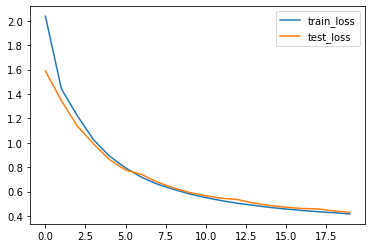

In [14]:
# plot the loss and acc
plot_loss(train_loss_history, test_loss_history, 'ddc')